In [3]:
import sys
import os

# Añadir la ruta raíz del proyecto al path de Python
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "..")))


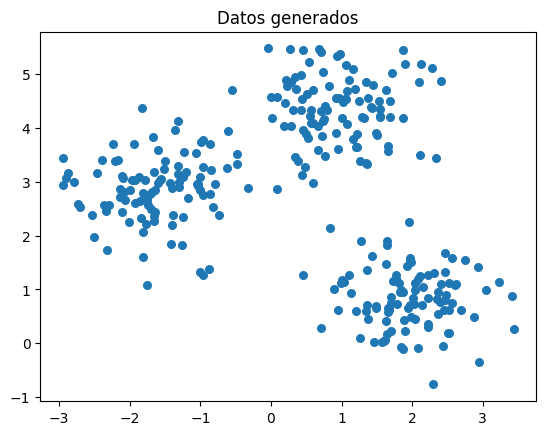

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np

# Datos sintéticos con 3 clusters
X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

plt.scatter(X[:, 0], X[:, 1], s=30)
plt.title("Datos generados")
plt.show()


In [4]:
from src.gmm import GMM

# Usamos KMeans para inicialización
gmm_kmeans = GMM(n_components=3, init_method="kmeans", verbose=True)
gmm_kmeans.fit(X)
labels_kmeans = gmm_kmeans.predict(X)

# Ahora con inicialización aleatoria
gmm_random = GMM(n_components=3, init_method="random", verbose=True)
gmm_random.fit(X)
labels_random = gmm_random.predict(X)


Iter 0: log-likelihood = -994.8315
Iter 1: log-likelihood = -895.9146
Iter 2: log-likelihood = -866.7701
Iter 3: log-likelihood = -865.8858
Iter 4: log-likelihood = -865.8647
Iter 5: log-likelihood = -865.8631
Iter 6: log-likelihood = -865.8628
Iter 7: log-likelihood = -865.8627
Iter 0: log-likelihood = -1062.8929
Iter 1: log-likelihood = -1021.3898
Iter 2: log-likelihood = -977.8344
Iter 3: log-likelihood = -965.9617
Iter 4: log-likelihood = -965.7423
Iter 5: log-likelihood = -965.7021
Iter 6: log-likelihood = -965.6629
Iter 7: log-likelihood = -965.6147
Iter 8: log-likelihood = -965.5561
Iter 9: log-likelihood = -965.4875
Iter 10: log-likelihood = -965.4116
Iter 11: log-likelihood = -965.3325
Iter 12: log-likelihood = -965.2550
Iter 13: log-likelihood = -965.1835
Iter 14: log-likelihood = -965.1210
Iter 15: log-likelihood = -965.0683
Iter 16: log-likelihood = -965.0248
Iter 17: log-likelihood = -964.9890
Iter 18: log-likelihood = -964.9591
Iter 19: log-likelihood = -964.9335
Iter 20:

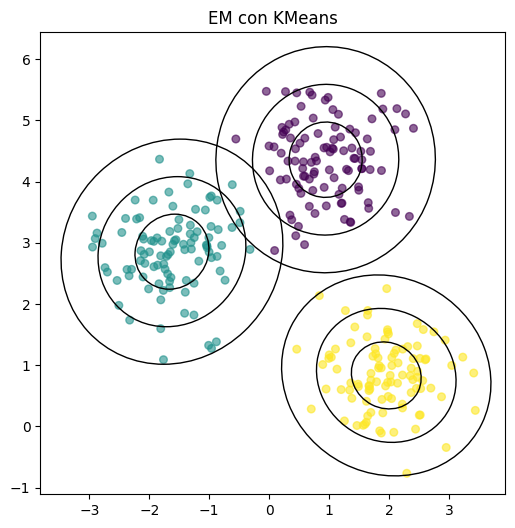

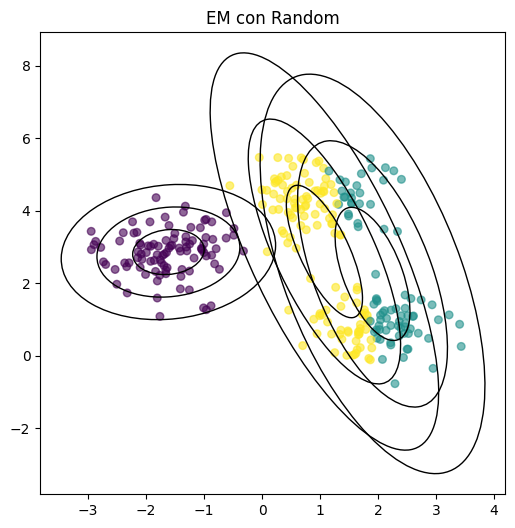

In [ ]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def plot_clusters(X, labels, means, covariances, title="Clusters"):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=30, cmap='viridis', alpha=0.6)

    for mean, cov in zip(means, covariances):
        draw_ellipse(mean, cov)

    plt.title(title)
    plt.show()

def draw_ellipse(mean, cov, ax=None, **kwargs):

    ax = ax or plt.gca()

    if cov.shape == (2, 2):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

        for nsig in range(1, 4):
            width, height = 2 * nsig * np.sqrt(vals)
            ell = Ellipse(xy=mean, width=width, height=height,
                          angle=angle, edgecolor='black', facecolor='none', **kwargs)
            ax.add_patch(ell)

# Visualización
plot_clusters(X, labels_kmeans, gmm_kmeans.means_, gmm_kmeans.covariances_, title="EM con KMeans")
plot_clusters(X, labels_random, gmm_random.means_, gmm_random.covariances_, title="EM con Random")


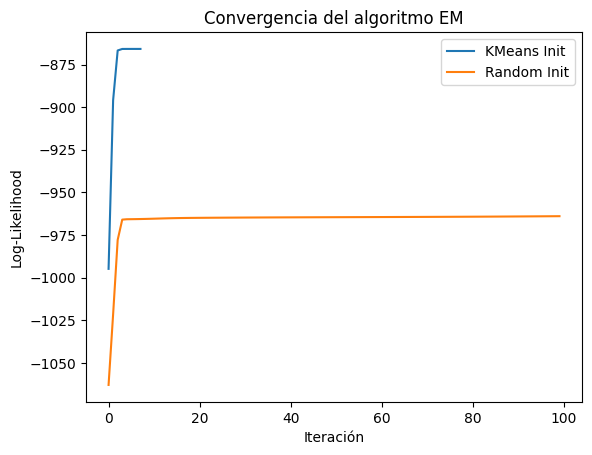

In [6]:
plt.plot(gmm_kmeans.log_likelihood_, label="KMeans Init")
plt.plot(gmm_random.log_likelihood_, label="Random Init")
plt.xlabel("Iteración")
plt.ylabel("Log-Likelihood")
plt.title("Convergencia del algoritmo EM")
plt.legend()
plt.show()
